In [1]:
import concurrent.futures
import matplotlib.pyplot as plt
import multiprocess as mp
import numpy as np
import pandas as pd
import random
import sys
import torch
import time

from collections import deque
from graph_utils import plot_network
from python_tsp.exact import solve_tsp_dynamic_programming
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
# from torchsummary import summary

from agent import Agent
from env import TSPEnv
from model import QNetwork
from solver import solve, solve2

%load_ext autoreload
%autoreload 2

/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [2]:
def get_solution(env, exact_solution_max_size=30, return_path=False):
    if env.G.number_of_nodes() <= exact_solution_max_size:
        dist_matrix = np.array([[env.G[u].get(v, {}).get('weight', float('inf')) for v in range(env.n)] for u in range(env.n)])
        solution = solve_tsp_dynamic_programming(dist_matrix)
        if not return_path:
            solution = solution[1]
        return solution
    else:
        return float('inf')

In [3]:
def run_validation(agent, env, n_episodes_validation, exact_solution_max_size=20, print_to_file=sys.stdout):
    agent.qnetwork_target.eval()
    agent.qnetwork_local.eval()
    val_scores = []
    for i in range(1, n_episodes_validation+1):
        score, _ = run_episode(agent, env, train_mode=False)
        solution = get_solution(env, exact_solution_max_size)
        approximation_ration = -score/solution
        val_scores.append(approximation_ration)
    
    val_scores = np.array(val_scores)
    val_stats = pd.Series(val_scores).describe()
    print(
        f"[Validation] "
        f"Mean: {val_stats['mean']}, "
        f"Std dev: {val_stats['std']}, "
        f"Optimal: {100 * (val_scores == 1.0).sum() / n_episodes_validation :.2f}%",
        file=print_to_file
    )
    
    agent.qnetwork_target.train()
    agent.qnetwork_local.train()

    return val_stats

In [4]:
def run_episode(agent, env, eps_start=0, eps_decay=0, eps_end=0, train_mode=True):
    state = env.reset()
    agent.reset_episode(env.G)
    score = 0
    eps = eps_start
    while True:
        action = agent.act(state, eps=eps if train_mode else 0)
        next_state, reward, done = env.step(action)
        score += reward
        if train_mode:
            eps = max(eps * eps_decay, eps_end)
            agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    return score, eps

In [44]:
def train(agent, env, eps_start, eps_decay, eps_end, scheduler=None, n_episodes=10000,
          start_episode=1, validate_each=25, n_episodes_validation=10, print_train_metrics_each=100,
          print_thetas=True, validate_at_start=True, print_to_file=sys.stdout):
    scores = []
    val_scores = []
    eps = eps_start
    start_time = time.time()
    if validate_at_start:
        val_score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
        val_scores.append(val_score)
    for episode_idx in range(start_episode, n_episodes + 1):
        try:
            # run episode for given episode_idx
            score, eps = run_episode(agent, env, eps, eps_decay, eps_end, train_mode=True)
            scores.append(score)
            
            # update the LR scheduler
            if isinstance(scheduler, LambdaLR):
                scheduler.step()

            if episode_idx % print_train_metrics_each == 0:
                print(
                    f"[{episode_idx}/{n_episodes}] "
                    f"loss: {agent.losses[-1]:.3e}, "
                    f"q_target: {agent.q_targets[-1]:.3e}, "
                    f"q_expected: {agent.q_expecteds[-1]:.3e}, "
                    f"eps: {eps:.4f}, "
                    f"time: {time.time() - start_time:.2f}s",
                    file=print_to_file,
                    flush=True
                )
                if print_thetas:
                    print(f"    θ1: {agent.theta1s[-1]:.3e}, "
                        f"θ2: {agent.theta2s[-1]:.3e}, "
                        f"θ3: {agent.theta3s[-1]:.3e}, "
                        f"θ4: {agent.theta4s[-1]:.3e}, "
                        f"θ5: {agent.theta5s[-1]:.3e}, "
                        f"θ6: {agent.theta6s[-1]:.3e}, "
                        f"θ7: {agent.theta7s[-1]:.3e}",
                        file=print_to_file
                    )
            
            # check if we should run validation
            if episode_idx % validate_each == 0:
                score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
                if isinstance(scheduler, ReduceLROnPlateau):
                    scheduler.step(score)
                val_scores.append(score)
        except KeyboardInterrupt:
            print(f"Training interrupted in episode #{episode_idx}")
            break
    print(f"Total time: {time.time() - start_time:.2f}s", file=print_to_file)
    return scores, val_scores

In [45]:
def eps_analysis(eps_start, eps_decay, eps_end, n, check_episodes=35000):
    return np.argmin([eps_start * (eps_decay ** (n*i)) > eps_end for i in range(check_episodes)])

In [46]:
def lr_lambda(lr_config):
    '''
    lr_config: list of tuples (start_episode, lr_value)
    '''
    def f(episode):
        for i in range(len(lr_config) - 1, -1, -1):
            start_episode, lr_value = lr_config[i]
            if episode >= start_episode:
                return lr_value
        raise ValueError("lr_config should have its first element starting at episode 0")
    return f

In [47]:
def plot_graphs(agent_losses, val_scores, n, lr_config, max_loss=1e0, filename=None):
    agent_losses, val_scores = np.atleast_2d(agent_losses, val_scores)    
    
    title_config = f'n = {n}, lr = {lr_config}'
    fig, ax = plt.subplots(2, 1, figsize=(10,8))
    
    losses_df = pd.DataFrame(agent_losses).T
    losses_df.plot(color='b', alpha=0.05, legend=False, xlabel='Minibatch', ylabel='Loss Value', ax=ax[0]);
    losses_df.mean(axis=1).plot(color='r', title=f'Loss Function\n{title_config}', ax=ax[0]);

    ax[0].set_title(f'Loss function\n{title_config}')
    ax[0].set_ylim((0, max_loss))
    
    val_df = pd.DataFrame(val_scores).T
    val_df.plot(color='b', alpha=0.05, legend=False, xlabel='Validation Episode', ylabel='Approximation Ratio', ax=ax[1]);
    val_df.mean(axis=1).plot(color='r', title=f'Validation scores\n{title_config}', ax=ax[1]);
    ax[1].set_title('Validation scores')

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

## Run grid of parameters

In [48]:
def run_train(experiment_idx, n_runs, p):
    all_agent_losses = []
    all_val_scores = []
    
    n = p['n']
    n_episodes = p['n_episodes']
    eps_start = p['eps_start']
    eps_end = p['eps_end']
    eps_end_at_episode = p['eps_end_at_episode']
    
    # transform relative to absolute episode number
    lr_config = p['lr_config']
    lr_config = [(int(ep * n_episodes), lr) if 0 < ep < 1 else (ep, lr) for (ep, lr) in lr_config]
    
    filename = 'outputs/run_{}.{}'
    f_log = open(filename.format(experiment_idx, 'log'), 'w')
    f_loss = open(filename.format(f'{experiment_idx}_loss', 'log'), 'w')
    f_val = open(filename.format(f'{experiment_idx}_val', 'log'), 'w')
    filename_plot = filename.format(experiment_idx, 'png')
    
    print(p)
    print(p, file=f_log)
    
    for run_idx in range(n_runs):
        agent = Agent(
            nstep=p.get('nstep', 1),
            normalize=p.get('normalize', True),
            lr=1 # LR is set via LR scheduler 
        )
        
        env = TSPEnv(n_min=n, n_max=n)

        scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(lr_config), verbose=False)

        if 0 < eps_end_at_episode < 1:
            eps_end_at_episode = round(eps_end_at_episode * n_episodes)
        # decay derived from formula eps_end = eps_start * (eps_decay ** (n * episode))
        eps_decay = (eps_end / eps_start) ** (1 / (n * eps_end_at_episode))

        print(f'Starting run #{run_idx+1}/{n_runs}...')
        print(f'Starting run #{run_idx+1}/{n_runs}...', file=f_log)
        scores, val_scores = train(
            agent, env, eps_start, eps_decay, eps_end,
            scheduler=scheduler, n_episodes=n_episodes,
            validate_each=p['validate_each'], print_train_metrics_each=p['print_train_metrics_each'],
            print_thetas=False, print_to_file=f_log)

        all_agent_losses.append(agent.losses)
        all_val_scores.append(val_scores)

    # print(f"{filename.format(experiment_idx, 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_loss', 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_val', 'log')=}")
    # print(f"{all_agent_losses=}")
    # print(f"{all_val_scores=}")

    print(all_agent_losses, file=f_loss)
    print(all_val_scores, file=f_val)
    
    f_log.close()
    f_loss.close()
    f_val.close()
#     with open(filename.format(f'{experiment_idx}_loss', 'log'), 'w') as f:
#         f.write(str(all_agent_losses))

#     with open(filename.format(f'{experiment_idx}_val', 'log'), 'w') as f:
#         f.write(str(all_val_scores))

    # print(filename.format(experiment_idx, 'png'))
    plot_graphs(all_agent_losses, all_val_scores, n, lr_config, max_loss=1, filename=filename_plot)

In [49]:
def run_train_from_params(params, n_runs, parallel=0, start_idx=0):
    '''
    parallel: 0 for sequential, -1 to use #processes = #param configs, >0 to use this number of processes
    '''
    parameter_grid = list(enumerate(ParameterGrid(params)))
    if parallel == 0:
        for experiment_idx, p in parameter_grid:
            run_train(start_idx + experiment_idx, n_runs, p)
    else:
        raise NotImplemented("Parallel version still not working as expected")
        # ctx = mp.get_context('spawn')
        # max_workers = parallel if parallel > 0 else len(parameter_grid)
        # with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        #     future_to_idx = {executor.submit(run_train, start_idx + idx, p): start + idx for idx, p in parameter_grid}
        #     for future in concurrent.futures.as_completed(future_to_idx):
        #         idx = future_to_idx[future]
        #         try:
        #             data = future.result()
        #         except Exception as exc:
        #             print(f'Idx {idx} generated an exception: {exc}')
        #         else:
        #             print(f'Idx {idx} successful')
        # with ctx.Pool(pool_size) as pool:
        #     pool.starmap(run_train, parameter_grid)

In [50]:
n_runs = 3
params = {
    'lr_config': [[[0, 5e-4]], [[0, 1e-3], [0.3, 1e-4]], [[0, 1e-3], [0.25, 1e-4], [0.75, 1e-5]]],
    'n': [8, 12, 15],
    # 'n': [3, 4, 5],
    'n_episodes': [20000],
    # 'n_episodes': [100],
    'eps_start': [1.00],
    'eps_end': [0.01],
    'eps_end_at_episode': [0.6],
    'validate_each': [500],
    'print_train_metrics_each': [50],
}

In [ ]:
run_train_from_params(params, n_runs, parallel=0, start_idx=0)

{'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'eps_start': 1.0, 'lr_config': [[0, 0.0005]], 'n': 8, 'n_episodes': 20000, 'print_train_metrics_each': 50, 'validate_each': 500}
Starting run #1/3...
Starting run #2/3...
Starting run #3/3...
{'eps_end': 0.01, 'eps_end_at_episode': 0.6, 'eps_start': 1.0, 'lr_config': [[0, 0.0005]], 'n': 12, 'n_episodes': 20000, 'print_train_metrics_each': 50, 'validate_each': 500}
Starting run #1/3...
Starting run #2/3...
Starting run #3/3...


## Ad hoc

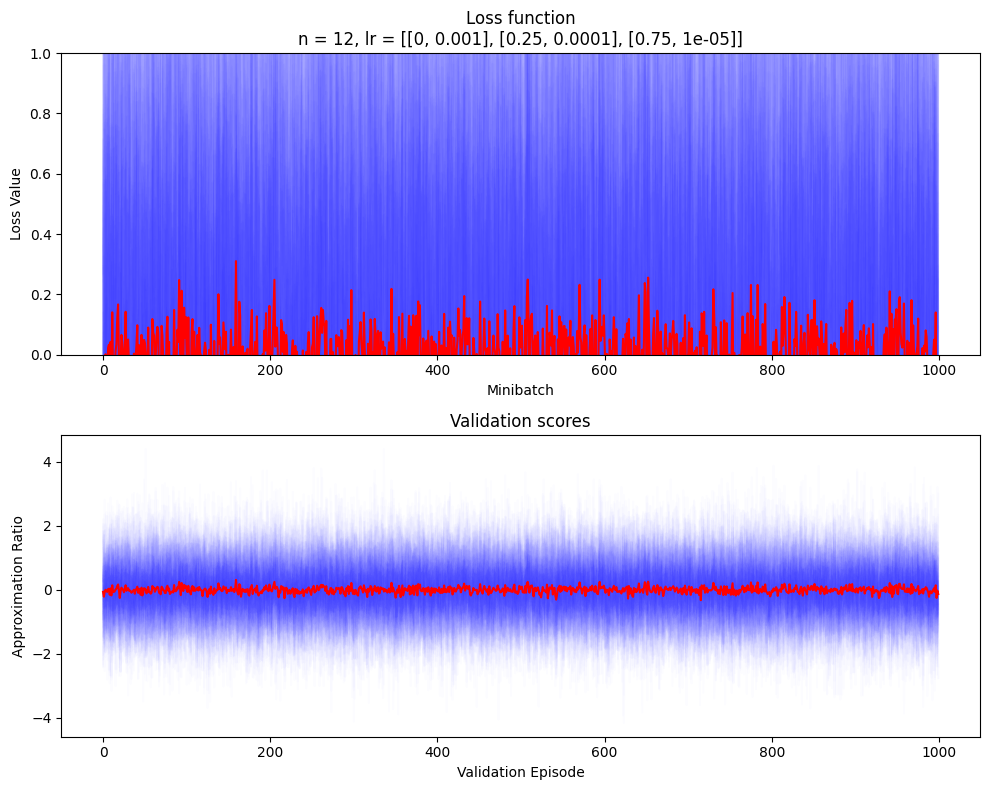

In [90]:
plot_graphs(val_scores, val_scores, 12, [[0, 1e-3], [0.25, 1e-4], [0.75, 1e-5]])

In [66]:
val_scores

array([[7.12105270e-01, 1.21824541e+00, 1.41877654e+00, ...,
        5.04552391e+02, 5.05287404e+02, 5.05894467e+02],
       [3.68693388e-01, 1.29393087e+00, 2.03704893e+00, ...,
        4.92329405e+02, 4.93101621e+02, 4.93549286e+02],
       [3.59529783e-01, 9.74650535e-01, 1.51889727e+00, ...,
        4.98274203e+02, 4.99033398e+02, 4.99296405e+02],
       ...,
       [6.78932081e-01, 1.19289108e+00, 1.34299626e+00, ...,
        4.96337584e+02, 4.96814465e+02, 4.97309958e+02],
       [1.59687469e-01, 5.73360104e-01, 9.91728014e-01, ...,
        5.01480114e+02, 5.01765746e+02, 5.02751517e+02],
       [1.86262553e-01, 7.19272093e-01, 7.68727325e-01, ...,
        4.88681500e+02, 4.88900478e+02, 4.89320184e+02]])

In [71]:
val_scores = np.random.randn(100, 1000)
val_scores

array([[-2.42386186,  0.74976138, -1.76439347, ...,  2.08580175,
        -0.28106727,  0.98491216],
       [-0.91003602,  0.55229264,  0.61816895, ...,  0.38922188,
         0.65689806,  0.73197172],
       [-1.16195723, -1.24923684,  0.96445519, ...,  0.2588779 ,
        -1.03373772, -0.39126439],
       ...,
       [ 0.28770022, -1.79838283, -0.46599777, ...,  0.04920869,
        -0.87257615,  0.09540195],
       [-0.02768871,  0.76783102,  0.69426978, ..., -0.98912241,
         2.27648186, -0.11971266],
       [ 1.97307178,  1.16808203,  0.1591288 , ...,  1.12297181,
         2.02148336,  0.43066722]])

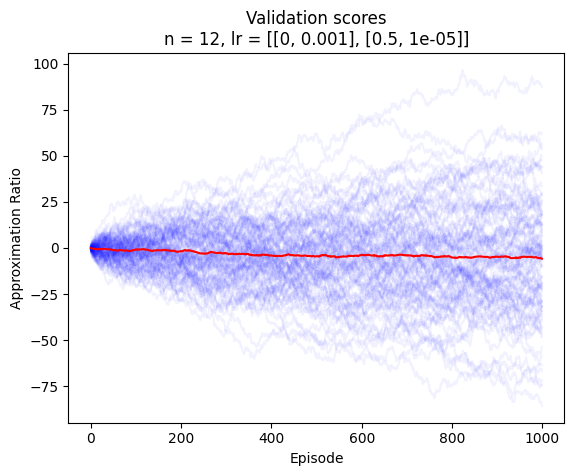

In [74]:
df = pd.DataFrame(np.cumsum(val_scores, axis=1)).T
df.plot(color='b', alpha=0.05, legend=False, xlabel='Episode', ylabel='Approximation Ratio');
df.mean(axis=1).plot(color='r', title=f'Validation scores\nn = {n}, lr = {lr}');

In [49]:
n = 12
lr = [[0, 1e-3], [0.5, 1e-5]]

In [52]:
', '.join([f'{p} = {v[0]}' for (p, v) in params.items()])

'n = 8, lr_config = [[0, 0.0005]], n_episodes = 100, eps_start = 1.0, eps_end = 0.01, eps_end_at_episode = 0.6, validate_each = 50, print_train_metrics_each = 10'

In [2]:
# Single step
env = TSPEnv(n_min=10, n_max=10)
agent = Agent(nstep=1)

In [3]:
state = env.reset()
agent.reset_episode(env.G)
score = 0
i = 0

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
state.shape

(10, 24)

In [6]:
state = env.reset()
agent.reset_episode(env.G)
print(env.start_vertex)
while True:
    action = agent.act(state, eps=0.1)
    print(action)
    next_state, reward, done = env.step(action)
    score += reward
    # print('reward', reward)
    agent.step(state, action, reward, next_state, done)
    i += 1
    state = next_state
    if done:
        break

0
8
2
9
4
7
3
6
1
5


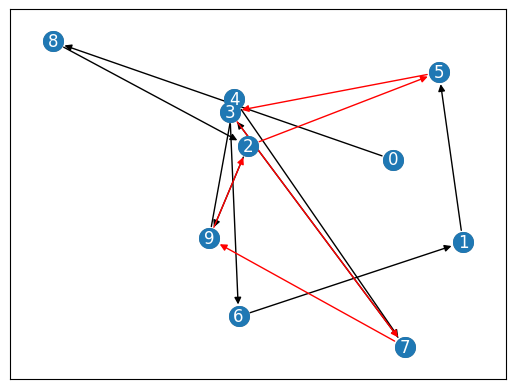

In [9]:
plot_network(env.G, env.tour, [2,5,3,7,9,2], draw_all_edges=False);

In [10]:
torch.__version__

'1.13.1'

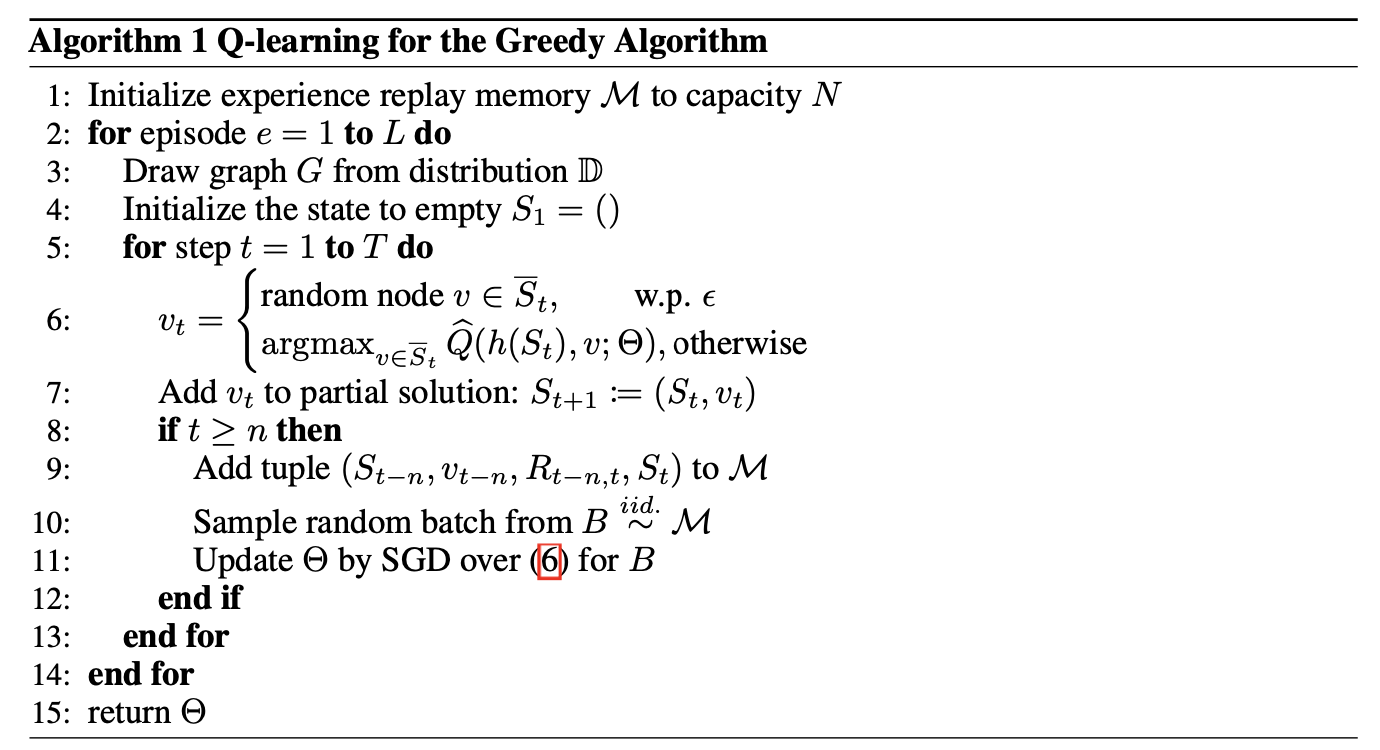

In [11]:
eps_start = 0.999
eps_decay = 0.99995 # 0.995
eps_end=0.01
n_batches = 200000

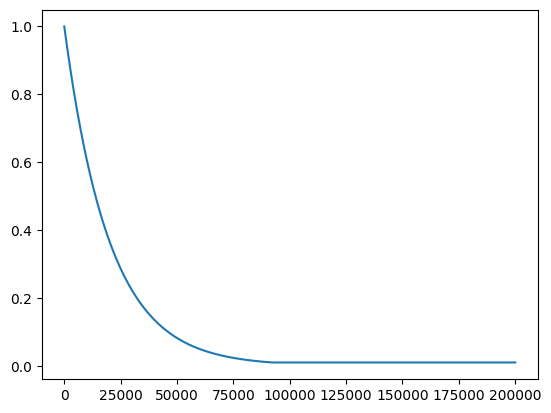

In [12]:
plt.plot([max(eps_start * eps_decay**i, eps_end) for i in range(n_batches)])

In [11]:
dist_matrix = np.array([[env.G[u].get(v, {}).get('weight', float('inf')) for v in range(env.n)] for u in range(env.n)])
solve_tsp_dynamic_programming(dist_matrix)

([0, 7, 6, 3, 2, 1, 4, 5, 8, 9], 2.2670917470301357)

In [18]:
eps_analysis(0.9999, 0.999985, 0.01, 15)

20467

In [19]:
max(0.01, 0.9999 * (0.999985 ** (15*10000)))

0.1053869062027777

In [22]:
nstep = 1
normalize=True
lr=1e-4
eps_start = 0.9999
eps_decay = 0.999985
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr)
env = TSPEnv(n_min=12, n_max=12)
scheduler = None
scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=4)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=20000, validate_each=1000, print_train_metrics_each=50)

[Validation] Mean: 1.5337033183750683, Std dev: 0.11584419012804405, Optimal: 0.00%
[50/20000] loss: 7.366e-02, q_target: -1.434e+00, q_expected: -1.133e+00, eps: 0.9917, time: 4.29s
    θ1: -1.786e-01, θ2: -1.161e-01, θ3: -1.571e-02, θ4: -1.680e-02, θ5: 5.459e-02, θ6: -6.162e-02, θ7: -4.747e-02
[100/20000] loss: 6.342e-02, q_target: -1.314e+00, q_expected: -1.027e+00, eps: 0.9835, time: 7.94s
    θ1: -1.842e-01, θ2: -1.157e-01, θ3: -1.389e-02, θ4: -1.722e-02, θ5: 5.379e-02, θ6: -6.143e-02, θ7: -4.779e-02
[150/20000] loss: 4.922e-02, q_target: -1.105e+00, q_expected: -9.302e-01, eps: 0.9755, time: 11.58s
    θ1: -1.865e-01, θ2: -1.141e-01, θ3: -1.233e-02, θ4: -1.745e-02, θ5: 5.292e-02, θ6: -6.121e-02, θ7: -4.835e-02
[200/20000] loss: 9.865e-02, q_target: -1.315e+00, q_expected: -8.359e-01, eps: 0.9674, time: 15.05s
    θ1: -1.886e-01, θ2: -1.144e-01, θ3: -1.314e-02, θ4: -1.770e-02, θ5: 5.212e-02, θ6: -6.110e-02, θ7: -4.872e-02
[250/20000] loss: 4.572e-02, q_target: -1.080e+00, q_expect

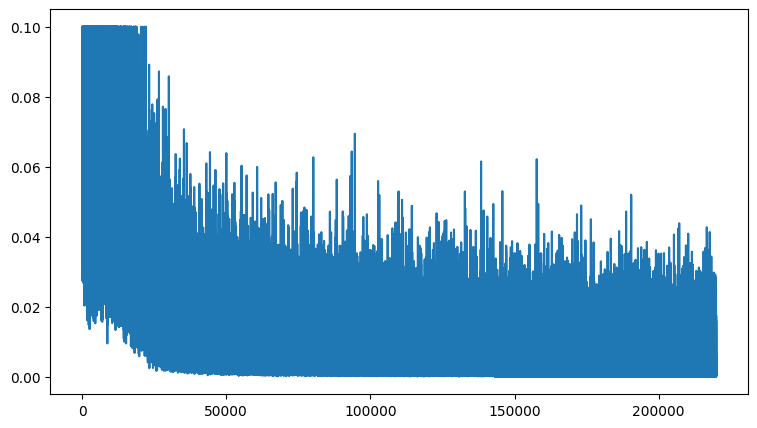

In [24]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e-1) for loss in agent_losses]);

<AxesSubplot: >

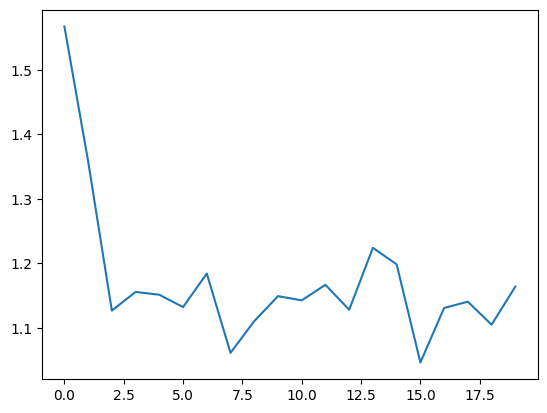

In [25]:
pd.Series(np.array(_[1])).plot()

In [43]:
nstep = 1
normalize=True
lr=1
eps_start = 0.9999
eps_decay = 0.99925
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr)
env = TSPEnv(n_min=15, n_max=15)
# scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=10, factor=0.1)
scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(300, 1e-2, 5e-4), verbose=False)

scores, val_scores = train(
    agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
    n_episodes=1000, validate_each=100, print_train_metrics_each=10,
    print_thetas=False, validate_at_start=False
)

[10/1000] loss: 8.353e-02, q_target: -1.073e+00, q_expected: -5.244e-01, eps: 0.9002, time: 1.40s
[20/1000] loss: 4.939e-02, q_target: -1.066e+00, q_expected: -6.506e-01, eps: 0.8104, time: 2.81s
[30/1000] loss: 3.088e-02, q_target: -1.068e+00, q_expected: -6.691e-01, eps: 0.7296, time: 4.24s
[40/1000] loss: 8.237e-02, q_target: -1.000e+00, q_expected: -6.061e-01, eps: 0.6569, time: 5.70s
[50/1000] loss: 1.168e-01, q_target: -1.569e+00, q_expected: -5.930e-01, eps: 0.5914, time: 7.18s
[60/1000] loss: 1.208e-01, q_target: -1.003e+00, q_expected: -8.437e-01, eps: 0.5324, time: 8.61s
[70/1000] loss: 9.848e-02, q_target: -1.331e+00, q_expected: -7.583e-01, eps: 0.4793, time: 10.05s
[80/1000] loss: 6.921e-02, q_target: -8.402e-01, q_expected: -9.390e-01, eps: 0.4315, time: 11.55s
[90/1000] loss: 1.049e-01, q_target: -8.913e-01, q_expected: -9.423e-01, eps: 0.3885, time: 13.01s
actions: [4, 3, 8, 7, 2, 5, 13, 5, 2, 10, 12, 4, 6, 7, 5, 1]
q_expected: [86.47374, 1.3465035, -0.52626413, 1721.07

SystemExit: 0

/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


- Picos na loss function com LR = $10^{-2}$
- {8,12} vértices
- 20000 episódios
- $\{10^{-3}, 10^{-4}, 10^{-5}\}$ / {fixo, variando} LR
- múltiplas (2-3) instâncias para cada configuração

In [13]:
def eps_analysis(eps_start, eps_decay, eps_end, n, check_episodes=35000):
    return np.argmin([eps_start * (eps_decay ** (n*i)) > eps_end for i in range(check_episodes)])

In [14]:
eps_analysis(0.9999, 0.999985000128196, 0.01, 15)

20467

In [15]:
es, ed, ee, n = 0.9999, 0.999985, 0.01, 15
epi = 20467

In [16]:
np.log(0.01/0.9999)/np.log(0.999985)/15

20466.82507946209

In [17]:
ed = (ee/es)**(1/(n*epi))
ed

0.999985000128196

In [ ]:
nstep = 1
normalize=True
lr=1
eps_start = 0.9999
eps_decay = 0.99925
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr, target_update="hard")
env = TSPEnv(n_min=10, n_max=10)
# scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=10, factor=0.1)
scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(0, 1e-4, 1e-4), verbose=False)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=10000, validate_each=50, print_train_metrics_each=10, print_thetas=False)

Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/history.py", line 831, in writeout_cache
    self._writeout_input_cache(conn)
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/history.py", line 814, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.IntegrityError: UNIQUE constraint failed: history.session, history.line

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/history.py", line 886, in run
    self.history_manager.writeout_cache(self.db)
  File "/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/Users/tiagomontalvao/.virtualenvs/msc/l

In [ ]:
def plot_graphs(agent, val_scores, max_loss=1e0, scores=None):
    agent_losses = agent.losses
    fig, ax = plt.subplots(2, 1, figsize=(10,8))
    ax[0].plot([min(loss, max_loss) for loss in agent_losses])
    plt.title('Loss function')
    pd.Series(np.array(_[1])).plot(ax=ax[1])
    plt.title('Validation scores')
    plt.show()

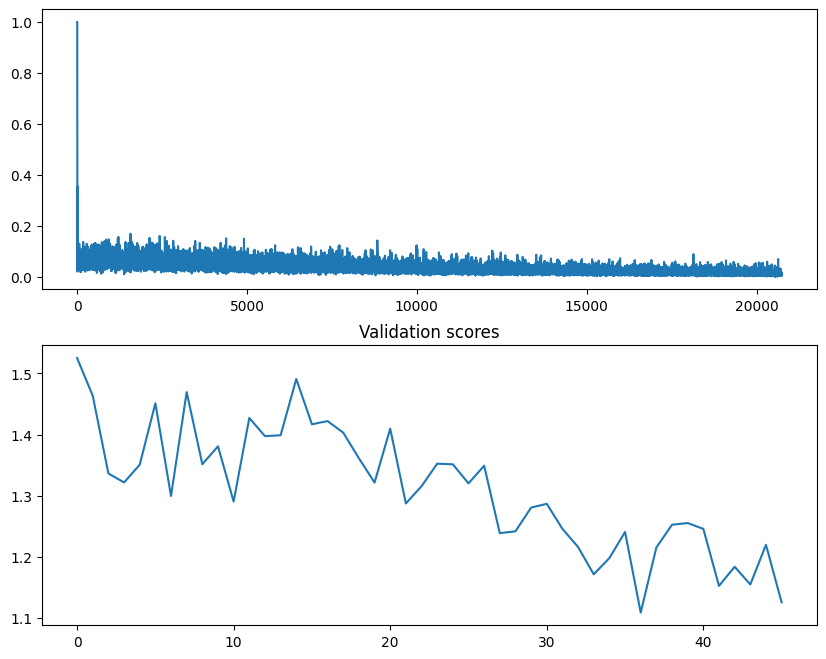

In [122]:
plot_graphs(agent, _[1], max_loss=1)

In [47]:
nstep = 1
normalize=True
lr=1e-2
eps_start = 0.9999
eps_decay = 0.999985
eps_end=0.01

agent = Agent(nstep=nstep, normalize=normalize, lr=lr, gamma=0.1)
env = TSPEnv(n_min=12, n_max=12, negate_reward=False)
scheduler = None
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=5, factor=0.1, verbose=True)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=40000, validate_each=50, print_train_metrics_each=50)

[Validation] Mean: 1.5256264679303075, Std dev: 0.23976849220655297, Optimal: 0.00%
loss=tensor(2.0495e+16, grad_fn=<MseLossBackward0>)
target_preds=tensor([[-0.9976, -0.9741, -0.9814, -0.9609, -0.9783, -0.9484, -0.9594, -0.9645,
         -0.9907, -0.9623, -0.9712, -0.9568],
        [-0.6438, -0.6349, -0.6149, -0.6266, -0.6208, -0.6059, -0.6246, -0.6031,
         -0.6617, -0.6505, -0.6097, -0.6115]], grad_fn=<SqueezeBackward1>)
invalid_actions_mask=tensor([[ True, False,  True, False, False, False, False, False, False,  True,
         False, False],
        [ True, False, False, False, False, False, False, False, False,  True,
         False, False]])
dones=tensor([[0.],
        [0.]])
1 - dones=tensor([[1.],
        [1.]])
states=tensor([[[1.0000, 0.0000, 0.7235, 0.9082, 0.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          0.0000, 0.6344, 0.4476, 0.7822, 0.2204, 0.6859, 0.7779, 0.6990,
          0.8067, 0.6002, 0.4032, 0.5

SystemExit: 0

/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


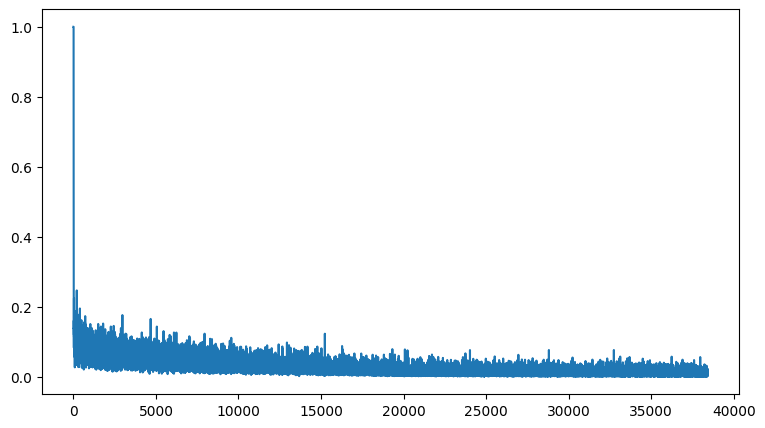

In [166]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e0) for loss in agent_losses]);

1000 episodios

<AxesSubplot: >

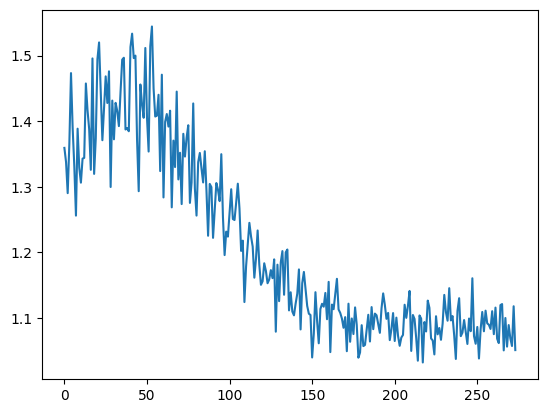

In [167]:
pd.Series(np.array(_[1])).plot()

In [148]:
agent.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [43]:
agent = Agent(nstep=1, normalize=True)
env = TSPEnv(n_min=15, n_max=15)
eps_start = 0.9999
eps_decay = 0.99997
eps_end=0.01
# scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=4)
scheduler = None

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=20000, validate_each=1000, print_train_metrics_each=50)

[50/20000] loss: 1.088e-01, q_target: -3.521e+00, q_expected: -3.383e+00, eps: 0.9777, time: 7.29s
    θ1: -2.203e-01, θ2: -1.138e-01, θ3: 3.296e-02, θ4: 4.621e-02, θ5: 6.268e-02, θ6: -7.568e-02, θ7: -1.043e-01
[100/20000] loss: 7.203e-02, q_target: -4.543e+00, q_expected: -4.144e+00, eps: 0.9559, time: 14.60s
    θ1: -2.215e-01, θ2: -1.132e-01, θ3: 3.345e-02, θ4: 4.613e-02, θ5: 6.277e-02, θ6: -7.487e-02, θ7: -1.035e-01
[150/20000] loss: 1.150e-01, q_target: -4.389e+00, q_expected: -4.525e+00, eps: 0.9346, time: 21.90s
    θ1: -2.224e-01, θ2: -1.144e-01, θ3: 3.391e-02, θ4: 4.612e-02, θ5: 6.275e-02, θ6: -7.442e-02, θ7: -1.031e-01
[200/20000] loss: 6.122e-02, q_target: -4.510e+00, q_expected: -4.331e+00, eps: 0.9138, time: 29.30s
    θ1: -2.212e-01, θ2: -1.156e-01, θ3: 3.393e-02, θ4: 4.701e-02, θ5: 6.239e-02, θ6: -7.270e-02, θ7: -1.015e-01
[250/20000] loss: 7.204e-02, q_target: -4.464e+00, q_expected: -4.909e+00, eps: 0.8935, time: 39.04s
    θ1: -2.224e-01, θ2: -1.145e-01, θ3: 3.333e-02

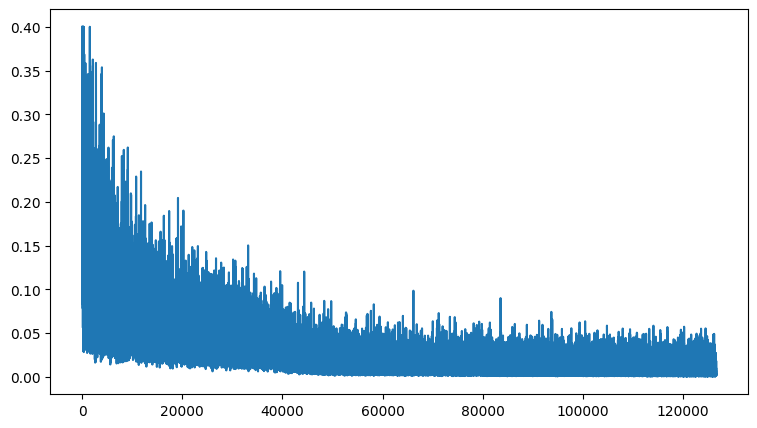

In [46]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 4e-1) for loss in agent_losses]);
# ax.plot(agent_losses);

In [50]:
run_episode?

Signature:
run_episode(
    agent,
    env,
    eps_start=0,
    eps_decay=0,
    eps_end=0,
    train_mode=True,
)
Docstring: <no docstring>
File:      /var/folders/y9/ss9wtkk10p1f9dvjc286650h0000gn/T/ipykernel_95463/1376195579.py
Type:      function

In [65]:
env = TSPEnv(n_min=3, n_max=3)

In [66]:
env.G[0]

AtlasView({1: {'weight': 0.5416754057136722, 'closest': 1}, 2: {'weight': 0.7352033098659809, 'closest': 2}})

In [67]:
solution_score

1.328338713966976

0 2
2 1
1 0


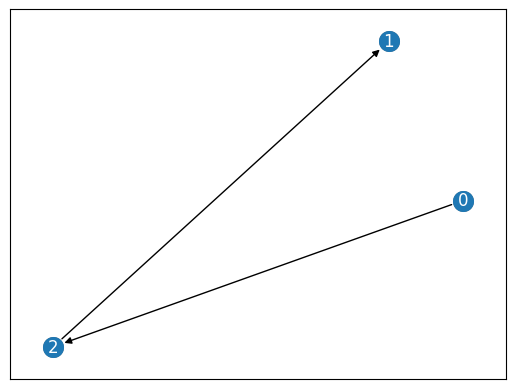

In [87]:
score, _ = run_episode(agent, env, train_mode=False)
solution_path, solution_score = get_solution(env, return_path=True)
plot_network(env.G, env.tour, [], draw_all_edges=False);

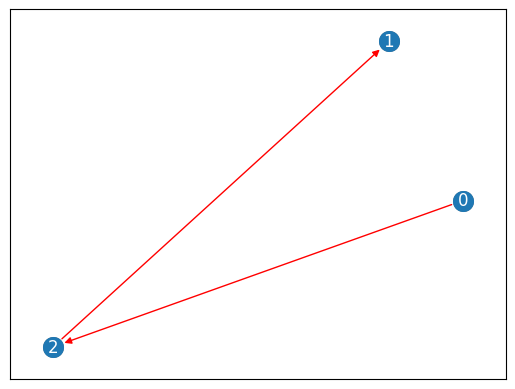

In [88]:
plot_network(env.G, [], solution_path, draw_all_edges=False);

In [89]:
env.tour

[0, 2, 1]

In [92]:
env.G[0][1]['weight'] + env.G[1][2]['weight'] + env.G[2][0]['weight']

0.9368325374132518

In [91]:
score, solution_score

(-0.9368325374132518, 0.9368325374132518)

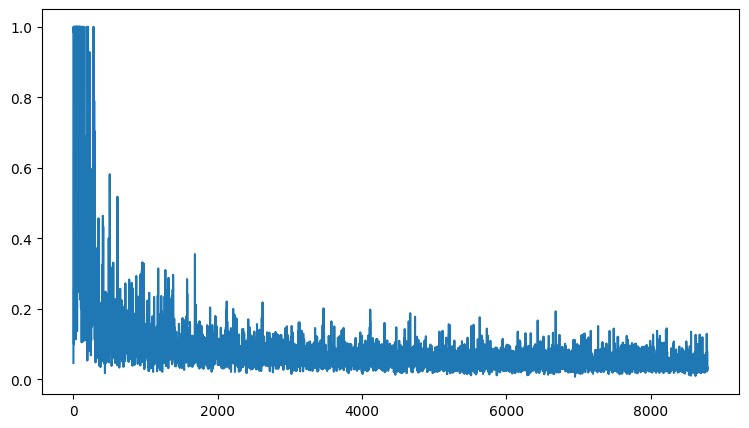

In [41]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e-0) for loss in agent.losses]);

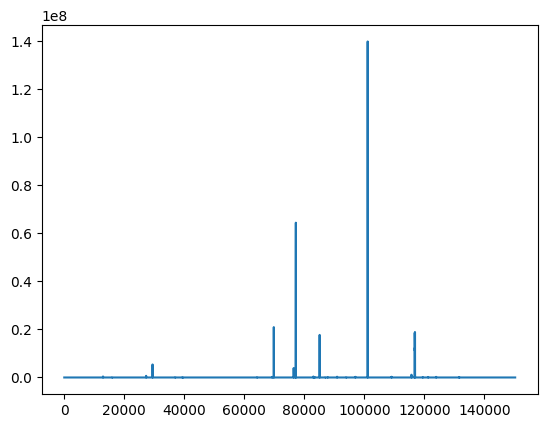

In [33]:
pd.Series(agent.losses).rolling(10).mean().plot();

In [ ]:
agent = Agent(nstep=1, normalize=True)
env = TSPEnv(n_min=15, n_max=15)
eps_start = 0.9999
eps_decay = 0.99997
eps_end=0.01
scheduler = ReduceLROnPlateau(agent.optimizer, 'min', patience=4)

_ = train(agent, env, eps_start, eps_decay, eps_end, scheduler=scheduler,
          n_episodes=20000, validate_each=100, print_train_metrics_each=1)

In [279]:
eps_start = 0.01
eps_decay = 0.01
eps_end=0.01

_ = train(agent, env, eps_start, eps_decay, eps_end, n_episodes=50000, start_episode=20001, validate_each=100, print_train_metrics_each=10)

/Users/tiagomontalvao/dev/ufrj/msc/tese/tsp-rl/agent.py:197: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:485.)
  if self.clip_grad_norm_value is not None:


[10/20000] loss: 3.312e-01, q_target: -9.826e-01, q_expected: -1.558e+00, eps: 0.9954, time: 0.48s
    θ1: -4.824e-02, θ2: 1.909e-02, θ3: 7.755e-02, θ4: -5.488e-02, θ5: 2.062e-02, θ6: 7.905e-02, θ7: 1.195e-02
[20/20000] loss: 1.167e+00, q_target: -4.123e-01, q_expected: -1.492e+00, eps: 0.9909, time: 0.87s
    θ1: -3.162e-02, θ2: 2.132e-02, θ3: 7.678e-02, θ4: -3.637e-02, θ5: 4.912e-02, θ6: 8.098e-02, θ7: 1.284e-02
[30/20000] loss: 4.139e-01, q_target: -1.739e+00, q_expected: -2.382e+00, eps: 0.9865, time: 1.25s
    θ1: 1.436e-02, θ2: 2.347e-02, θ3: 7.719e-02, θ4: -6.323e-02, θ5: 6.899e-02, θ6: 8.351e-02, θ7: 1.319e-02
[40/20000] loss: 2.111e-01, q_target: -1.994e+00, q_expected: -1.535e+00, eps: 0.9821, time: 1.65s
    θ1: 1.568e-02, θ2: 2.312e-02, θ3: 7.343e-02, θ4: -3.970e-02, θ5: 7.459e-02, θ6: 8.379e-02, θ7: 1.333e-02
[50/20000] loss: 5.069e-02, q_target: -2.401e+00, q_expected: -2.626e+00, eps: 0.9777, time: 2.06s
    θ1: 8.909e-02, θ2: 2.542e-02, θ3: 6.948e-02, θ4: -3.465e-02, θ5

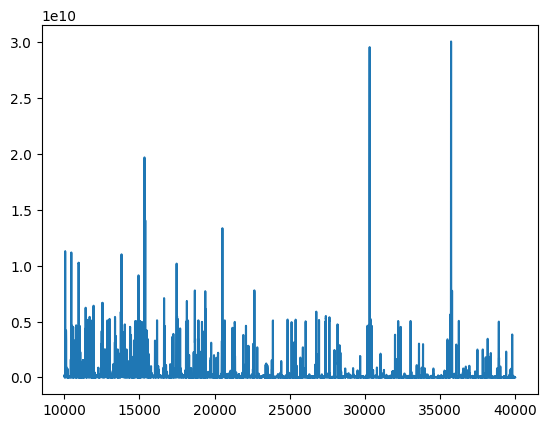

In [148]:
pd.Series(agent.losses).rolling(10).mean().iloc[10000:40000].plot();

In [81]:
agent = Agent(nstep=1)
env = TSPEnv(n_min=10, n_max=10)
eps_start = 0.9999
eps_decay = 0.999975
eps_end=0.01

train(agent, env, eps_start, eps_decay, eps_end, n_episodes=10000, validate_each=1000, print_train_metrics_each=100)

[100/10000] last loss: 1.251896e+05, eps: 0.9752120762781787, time: 4.91s
[200/10000] last loss: 1.876327e+05, eps: 0.9511337070895033, time: 9.88s
[300/10000] last loss: 1.877577e+05, eps: 0.9276498422931427, time: 14.75s
[400/10000] last loss: 6.256943e+04, eps: 0.904745803342154, time: 19.62s
[500/10000] last loss: 1.876346e+05, eps: 0.8824072741086795, time: 24.47s
[600/10000] last loss: 1.251067e+05, eps: 0.8606202919356861, time: 29.34s
[700/10000] last loss: 4.024520e-01, eps: 0.8393712389096226, time: 34.27s
[800/10000] last loss: 1.250741e+05, eps: 0.8186468333485748, time: 39.19s
[900/10000] last loss: 6.261039e+04, eps: 0.7984341215005684, time: 44.06s
[1000/10000] last loss: 6.262113e+04, eps: 0.7787204694468575, time: 48.95s
Validation score: 1.9008830725285044
[1100/10000] last loss: 1.877956e+05, eps: 0.7594935552051088, time: 54.16s
[1200/10000] last loss: 1.251666e+05, eps: 0.74074136102757, time: 59.12s
[1300/10000] last loss: 1.599262e-01, eps: 0.7224521658894084, ti

([-4.856717230218909,
  -3.9434659950709845,
  -5.406408677742485,
  -5.212160792766479,
  -6.17922373834866,
  -5.474619030841255,
  -5.10162548624097,
  -4.2952515473114845,
  -4.999302461872724,
  -4.437349922887374,
  -4.835148165032203,
  -3.8238806353895227,
  -5.624365409278787,
  -4.221190815443114,
  -5.933570772906371,
  -4.887661305684702,
  -6.530959094230221,
  -5.927058456432277,
  -5.959000348513109,
  -4.5741874816107035,
  -7.040044687338758,
  -4.55375087472426,
  -4.464715433526784,
  -5.9536460286763395,
  -5.116073038781616,
  -4.936944475799084,
  -5.59730826573967,
  -5.959033563312646,
  -6.223423911570786,
  -4.508882459343346,
  -6.4738198914111615,
  -5.216305614876741,
  -6.091345804039758,
  -5.398302030077374,
  -4.915469719441292,
  -5.658537723200518,
  -5.698093605628429,
  -4.314452833342501,
  -4.617927302062074,
  -4.705907344488062,
  -6.380487552551247,
  -4.725815530569934,
  -3.89489304072028,
  -4.646500721501766,
  -6.127902349330436,
  -5.4805

In [90]:
eps_start = 0.08207422522123975
eps_decay = 0.999975
eps_end=0.01

_ = train(agent, env, eps_start, eps_decay, eps_end, n_episodes=12000, start_episode=10001, validate_each=1000, print_train_metrics_each=100)

[10100/12000] last loss: 6.253707e+04, eps: 0.08004778036496472, time: 5.08s
[10200/12000] last loss: 6.254933e+04, eps: 0.07807136922809936, time: 9.93s
[10300/12000] last loss: 6.259468e+04, eps: 0.07614375645846076, time: 14.93s
[10400/12000] last loss: 1.876479e+05, eps: 0.0742637372051959, time: 19.77s
[10500/12000] last loss: 6.256938e+04, eps: 0.07243013636569232, time: 24.60s
[10600/12000] last loss: 6.254848e+04, eps: 0.07064180785108373, time: 29.46s
[10700/12000] last loss: 6.257757e+04, eps: 0.0688976338698862, time: 34.29s
[10800/12000] last loss: 6.260153e+04, eps: 0.06719652422932841, time: 39.11s
[10900/12000] last loss: 1.877743e+05, eps: 0.06553741565392568, time: 43.93s
[11000/12000] last loss: 1.251580e+05, eps: 0.06391927112088273, time: 48.76s
Validation score: 1.7638182380145042
[11100/12000] last loss: 3.712318e-01, eps: 0.06234107921190491, time: 53.79s
[11200/12000] last loss: 1.877332e+05, eps: 0.06080185348101211, time: 58.68s
[11300/12000] last loss: 6.2539

In [92]:
eps_start = 0.04978022283623802
eps_decay = 0.999975
eps_end=0.01

_ = train(agent, env, eps_start, eps_decay, eps_end, n_episodes=20000, start_episode=12001, validate_each=1000, print_train_metrics_each=100)

[12100/20000] last loss: 3.922556e-01, eps: 0.04855112958267623, time: 4.89s
[12200/20000] last loss: 1.876774e+05, eps: 0.04735238312428498, time: 9.70s
[12300/20000] last loss: 3.128713e+05, eps: 0.04618323418677233, time: 14.54s
[12400/20000] last loss: 3.127978e+05, eps: 0.045042951995723175, time: 19.40s
[12500/20000] last loss: 3.401004e-01, eps: 0.043930823819829504, time: 24.21s
[12600/20000] last loss: 2.931921e-01, eps: 0.04284615452539931, time: 29.78s
[12700/20000] last loss: 6.261700e+04, eps: 0.04178826614186448, time: 34.80s
[12800/20000] last loss: 1.876393e+05, eps: 0.04075649743801663, time: 39.65s
[12900/20000] last loss: 2.502718e+05, eps: 0.03975020350870535, time: 44.68s
[13000/20000] last loss: 3.129676e-01, eps: 0.038768755371741806, time: 49.57s
Validation score: 1.845805027549731
[13100/20000] last loss: 1.251271e+05, eps: 0.03781153957475449, time: 54.62s
[13200/20000] last loss: 1.251659e+05, eps: 0.03687795781175198, time: 59.53s
[13300/20000] last loss: 6.

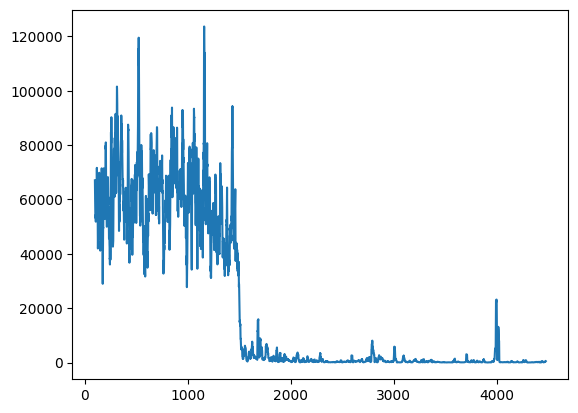

In [128]:
pd.Series(agent.losses).rolling(10).mean().iloc[100:].plot();

In [ ]:
L = 100000
validate_each = 50

agent = Agent(nstep=3)
env = TSPEnv(n_min=10, n_max=10)
scores = []
val_scores = []
eps = eps_start
t1 = time.time()
for episode in range(1, L+1):
    try:
        state = env.reset()
        validation = episode % validate_each == 0
        agent.reset_episode(env.G)
        score = 0
        while True:
            action = agent.act(state, eps=0 if validation else eps)
            next_state, reward, done = env.step(action)
            score += reward
            # print('reward', reward)
            if not validation:
                eps = max(eps*eps_decay, eps_end)
                agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores.append(score)
        if validation:
            dist_matrix = np.array([[env.G[u].get(v, {}).get("weight", float('inf')) for v in range(env.n)] for u in range(env.n)])
            solution_score = solve_tsp_dynamic_programming(dist_matrix)[1]
            val_scores.append(-score/solution_score)
            print(f"[{episode}/{L}] Final score: {-score/solution_score}, eps: {eps}, last loss: {agent.losses[-1]}")
    except KeyboardInterrupt:
        break
t2= time.time()
print("Total time:", t2 - t1)

[50/100000] Final score: 1.4989330444629003, eps: 0.9756995115134622, last loss: 250366.75


In [13]:
with open("losses.txt", "w") as f:
    for loss in agent.losses:
        f.write(f"{loss}\n")

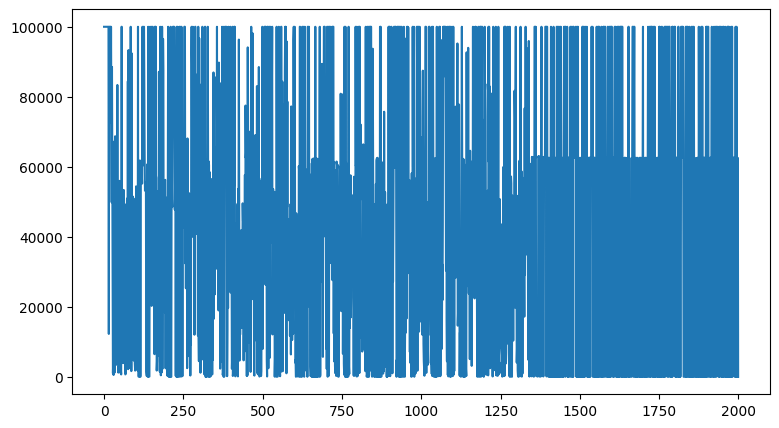

In [33]:
agent_losses = agent.losses
fig, ax = plt.subplots(figsize=(9,5))
ax.plot([min(loss, 1e5) for loss in agent.losses]);

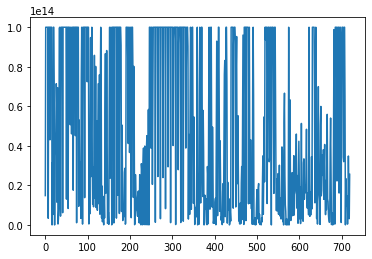

In [15]:
losses = [14828352569344.0, 2.2553684161121485e+17, 7.925906019241165e+16, 2026945927708672.0, 6147520908492800.0, 4790590952701952.0, 1045775748431872.0, 3328537526272.0, 2803780420632576.0, 3537677320192000.0, 1557000001421312.0, 43036276948992.0, 864137957605376.0, 1404930912944128.0, 1360519474708480.0, 489528561238016.0, 681001216.0, 31526202900480.0, 5276355788800.0, 143169933017088.0, 165171842514944.0, 72860429189120.0, 694849600.0, 35021872168960.0, 39365485002752.0, 47134816600064.0, 71460110467072.0, 61636253581312.0, 11415640342528.0, 69399029481472.0, 454729039872.0, 3017474834432.0, 8701980704768.0, 99380006748160.0, 207631503327232.0, 90076956590080.0, 4453146558464.0, 170504262516736.0, 807685041684480.0, 575021965639680.0, 263440425811968.0, 6169421152256.0, 282648844959744.0, 607427292561408.0, 563614733828096.0, 418518625419264.0, 348090221461504.0, 6017536944504832.0, 152786012471296.0, 154805351743488.0, 13053942824960.0, 146290964955136.0, 187953791893504.0, 250663871184896.0, 8314503036928.0, 149493852930048.0, 320251082309632.0, 240539509194752.0, 61384842805248.0, 50681981435904.0, 211961451118592.0, 234588681011200.0, 46062064631808.0, 85829108105216.0, 303882727063552.0, 234763935809536.0, 17563407876096.0, 121385749839872.0, 310846513217536.0, 221727351111680.0, 119424157745152.0, 45150445240320.0, 193869085933568.0, 141083266777088.0, 1098069245952.0, 377531114979328.0, 477581237288960.0, 501866458775552.0, 136008964243456.0, 9404967550976.0, 53086496227328.0, 21245462577152.0, 23358894768128.0, 31832615682048.0, 3330800091136.0, 73868387549184.0, 163046756450304.0, 75514567983104.0, 430829469696.0, 202684422422528.0, 401607996997632.0, 453803157487616.0, 245215805833216.0, 13781082046464.0, 237984926400512.0, 682463391121408.0, 1058522607386624.0, 653469811736576.0, 124538096451584.0, 72426360668160.0, 266900441399296.0, 353681295802368.0, 129265437769728.0, 469389410304.0, 38282926751744.0, 5527200858112.0, 55567603204096.0, 94778326777856.0, 24435226574848.0, 64822725050368.0, 133458315706368.0, 30125080969216.0, 10458600833024.0, 29468221505536.0, 9172272807936.0, 32599898587136.0, 85803170529280.0, 13424602906624.0, 33166542766080.0, 80179850379264.0, 8815578710016.0, 27713991606272.0, 52565051965440.0, 7435525292032.0, 36632803672064.0, 71374244675584.0, 42262897623040.0, 10653069737984.0, 75962100219904.0, 5426216173568.0, 71117779763200.0, 154482222563328.0, 75523334078464.0, 3550239784960.0, 19663052341248.0, 1612757729280.0, 6595897982976.0, 3445062631424.0, 57680666624.0, 14515368361984.0, 3500790775808.0, 56803836559360.0, 86652861022208.0, 16049253646336.0, 41142066348032.0, 88220482142208.0, 51359239897088.0, 759993401344.0, 2491876900864.0, 6405232263168.0, 279807131648.0, 58593634156544.0, 138298727071744.0, 23630408843264.0, 55376099672064.0, 151924955414528.0, 79462959939584.0, 38256230400.0, 329284874928128.0, 662981352357888.0, 556392612102144.0, 230335992299520.0, 981605351424.0, 283705507577856.0, 603376735748096.0, 684310428385280.0, 512603642134528.0, 240681964535808.0, 3448300371968.0, 119007327813632.0, 126278615171072.0, 14946636136448.0, 102475939971072.0, 222263014064128.0, 135153275895808.0, 5785487147008.0, 126166090383360.0, 307936236666880.0, 279239614005248.0, 90844380004352.0, 6784274661376.0, 50555854520320.0, 33780832141312.0, 2210407645184.0, 5527163633664.0, 9799954595840.0, 4173718355968.0, 26588378824704.0, 28653152894976.0, 376996003840.0, 865108361216.0, 1.2557672624685056e+16, 291575028514816.0, 428489995976704.0, 321140442529792.0, 80180563410944.0, 41173678817280.0, 213975807557632.0, 201846585032704.0, 36639485198336.0, 45212499968000.0, 119064764612608.0, 83770090717184.0, 3642112606208.0, 123495568637952.0, 297394172329984.0, 262892247056384.0, 77719454875648.0, 13904844423168.0, 80240600678400.0, 54777169838080.0, 104556519424.0, 933449695232.0, 25439435227136.0, 15373049004032.0, 13419386241024.0, 7615568936960.0, 6697495560192.0, 4401704468480.0, 16645812649984.0, 17135625568256.0, 1537877737472.0, 1034142547968.0, 25407889866752.0, 23579026522112.0, 691997704192.0, 54099038208.0, 30975992004608.0, 27800648024064.0, 371358597120.0, 83956219904.0, 31078752452608.0, 38895978807296.0, 446501945344.0, 178097504256.0, 39874375712768.0, 33642319446016.0, 1161290711040.0, 72386830336.0, 38946687942656.0, 45133458309120.0, 657785880576.0, 107091255296.0, 57982498897920.0, 58405544787968.0, 19784110080.0, 176492503891968.0, 322536306900992.0, 184450071658496.0, 42755174694912.0, 38800541614080.0, 147772997107712.0, 125541986336768.0, 20506912751616.0, 56162913353728.0, 1.1271006723244032e+16, 296224028622848.0, 378718673436672.0, 304072678703104.0, 132485992153088.0, 1345637056512.0, 205713162895360.0, 584198163267584.0, 758156821004288.0, 747838698946560.0, 337967050653696.0, 24463785590784.0, 123569723932672.0, 371609831473152.0, 482904144609280.0, 378363197784064.0, 164246159622144.0, 3133608034304.0, 351131830059008.0, 998430579097600.0, 1296638278631424.0, 1012354594635776.0, 438594174976000.0, 23937926823936.0, 208607182323712.0, 477663412092928.0, 606055788707840.0, 494671683911680.0, 230162633326592.0, 8223588352000.0, 237230236893184.0, 716986338246656.0, 930271461376000.0, 1017535466045440.0, 451983869739008.0, 29382817087488.0, 182114817409024.0, 536950838657024.0, 670094086635520.0, 544919177396224.0, 229963387109376.0, 1137123655680.0, 279581147791360.0, 776130588049408.0, 1008108214157312.0, 822095059615744.0, 382567937212416.0, 40150067314688.0, 94077894787072.0, 369446241697792.0, 490738735382528.0, 398234602176512.0, 159860830240768.0, 187253522432.0, 317241115541504.0, 847794533302272.0, 1090771637764096.0, 701286152404992.0, 323262861017088.0, 27930633699328.0, 91753713500160.0, 311417173442560.0, 398589071196160.0, 322710756392960.0, 140418704474112.0, 1207431725056.0, 159753221177344.0, 444392716369920.0, 556670811897856.0, 419385168625664.0, 159941545426944.0, 1891703193600.0, 146037947760640.0, 428524456378368.0, 540478818746368.0, 462342190006272.0, 256676036870144.0, 38883307814912.0, 79597227999232.0, 327616649232384.0, 438809325993984.0, 294828399132672.0, 90237841702912.0, 2968811732992.0, 43791041953792.0, 45741305233408.0, 5321363292160.0, 48651405623296.0, 1.2851663136096256e+16, 95138802040832.0, 7899247542272.0, 61036342280192.0, 156068458004480.0, 137462869393408.0, 44690401394688.0, 10887729512448.0, 54626762096640.0, 25949244489728.0, 216671633408.0, 995301523456.0, 8760984076288.0, 3986795003904.0, 9251038691328.0, 10438017286144.0, 1.005583914237952e+16, 9851753472.0, 25060435820544.0, 25921213956096.0, 331481153536.0, 70453863383040.0, 134803428999168.0, 97492712554496.0, 11096573345792.0, 48755025903616.0, 129660675424256.0, 117950891687936.0, 33977148637184.0, 14376836792320.0, 57908205191168.0, 37006293860352.0, 1333710336.0, 528180084736.0, 15015129120768.0, 7930036355072.0, 11019744182272.0, 13212643753984.0, 1330589990912.0, 121170821120.0, 29524181909504.0, 24922380304384.0, 628303527936.0, 60462444052480.0, 123402413146112.0, 84270932557824.0, 7970458435584.0, 48092892102656.0, 120744054882304.0, 133222562267136.0, 43176463171584.0, 9041375920128.0, 49507886694400.0, 29565579689984.0, 795521318912.0, 2546450038784.0, 7124970110976.0, 867491053568.0, 11513914982400.0, 13447769096192.0, 70687924224.0, 43104790904832.0, 92951808049152.0, 63546406731776.0, 4679745929216.0, 56621409501184.0, 146755005972480.0, 138461726113792.0, 47217347919872.0, 6867586121728.0, 42533249875968.0, 23782162956288.0, 2456792858624.0, 4033991933952.0, 1645760610304.0, 144698081280.0, 17081226493952.0, 20899159867392.0, 1228532875264.0, 36957157588992.0, 76059466792960.0, 83183886401536.0, 4175189245952.0, 75962100219904.0, 172231812448256.0, 171391240372224.0, 72334211809280.0, 911811084288.0, 21593195544576.0, 8949622374400.0, 7586895626240.0, 13197177257984.0, 2346433536.0, 834168029184.0, 6156750684160.0, 1951497191424.0, 1.0459564994461696e+16, 156290202468352.0, 255537367220224.0, 240139406147584.0, 123630734278656.0, 8479511150592.0, 91325701554176.0, 275459354918912.0, 351018214752256.0, 354583373152256.0, 93215319392256.0, 9064435154944.0, 79010335817728.0, 95299141894144.0, 25960900460544.0, 20883146014720.0, 55264711540736.0, 29103348514816.0, 1979829059584.0, 6597911248896.0, 628607942656.0, 441065996288.0, 11165702815744.0, 709705138176.0, 21315507453952.0, 29534963367936.0, 2721866317824.0, 46863554183168.0, 96026048331776.0, 53190649184256.0, 238925447168.0, 118988998705152.0, 237255369162752.0, 250210903130112.0, 119277852033024.0, 2178835808256.0, 182703882240000.0, 461571880910848.0, 566935884398592.0, 352381363552256.0, 1.860117049901056e+16, 10697033383936.0, 88047894921216.0, 107176496463872.0, 36526452899840.0, 10888943763456.0, 43061103034368.0, 15776338673664.0, 8156918841344.0, 17380627447808.0, 301330726912.0, 72159997198336.0, 127365124456448.0, 65969611341824.0, 283509391360.0, 1498234748928.0, 3668879867904.0, 8575500800.0, 2391649812480.0, 174476623872.0, 10607059271680.0, 17837445873664.0, 3107054944256.0, 8755870171136.0, 18767471968256.0, 20907793842176.0, 947460833280.0, 5384887074816.0, 220088582144.0, 759644749824.0, 955076182016.0, 30471192576.0, 3659293523968.0, 1514711154688.0, 20932015947776.0, 34919306756096.0, 5403839561728.0, 25203774062592.0, 54674904317952.0, 21797619630080.0, 1.0808694296018944e+16, 93661517840384.0, 185218602369024.0, 177194227728384.0, 111084178505728.0, 10825205022720.0, 49244127887360.0, 157440666501120.0, 195812340531200.0, 182369042563072.0, 31961565364224.0, 34191806824448.0, 114332205580288.0, 131979655774208.0, 76589383548928.0, 8644536320.0, 119521566261248.0, 358081456242688.0, 386619399995392.0, 232748706955264.0, 51534482112512.0, 15951141535744.0, 99886435401728.0, 109195307253760.0, 1.0626070139109376e+16, 63426697101312.0, 21398839885824.0, 7223924752384.0, 23299929145344.0, 7090588876800.0, 18231670603776.0, 25952585252864.0, 5395771293696.0, 16742695829504.0, 30206368677888.0, 11146142679040.0, 4418336980992.0, 13747187875840.0, 2989468680192.0, 9278554374144.0, 39456186826752.0, 38045801775104.0, 1639506116608.0, 14783840518144.0, 7545354240.0, 51792318562304.0, 66641098440704.0, 25282956230656.0, 10185136406528.0, 6874296483840.0, 239878144.0, 3131201028096.0, 159494799360.0, 2175860998144.0, 52554645504.0, 853258665984.0, 1.14994528124928e+16, 292546816.0, 39910450921472.0, 63276553601024.0, 26577488314368.0, 2219980881920.0, 14440182317056.0, 4432439803904.0, 26422890463232.0, 25798922731520.0, 4814689271808.0, 15132659810304.0, 35034845151232.0, 4995797221376.0, 15415737581568.0, 16277609381888.0, 18579340656640.0, 29702674710528.0, 45959828471808.0, 16824500486144.0, 8395621924864.0, 24968490385408.0, 843385077760.0, 22100228177920.0, 42303473319936.0, 23831267770368.0, 3080839495680.0, 19263742017536.0, 683995168768.0, 15094717087744.0, 51340663324672.0, 15138262351872.0, 3083929387008.0, 11366930841600.0, 1856133791744.0, 31431541653504.0, 33422642774016.0, 12924312616960.0, 19073274478592.0, 20030064427008.0, 16274962776064.0, 27966497095680.0, 48388162715648.0, 11013796659200.0, 8476389539840.0, 16194121760768.0, 12262715686912.0, 5095132495872.0, 1.1333231135686656e+16, 15872510918656.0, 4345257000960.0, 16793013846016.0, 5006245232640.0, 14345913237504.0, 34498144108544.0, 8108506611712.0, 8964729544376320.0, 146833523343360.0, 274066443337728.0, 296764020097024.0, 200287260246016.0, 62390028730368.0, 11171370369024.0, 72246601187328.0, 139508414676992.0, 72187042070528.0, 3216771383296.0, 23597909278720.0, 443747827712.0, 39200523026432.0, 69960642592768.0, 31612102246400.0, 15118161149952.0, 12037790892032.0, 255404900352.0, 50625614184448.0, 59936335724544.0, 14702868430848.0, 17699321151488.0, 35466980098048.0, 28987197751296.0, 25036333252608.0, 38074528563200.0, 12970427940864.0, 31718161514496.0, 40697356877824.0, 18210225127424.0, 5201756946432.0, 22495063179264.0, 7675160559616.0, 19584448987136.0, 55936995557376.0, 13115870674944.0, 11715011936256.0, 4956856778752.0, 1926033309696.0, 1302154838016.0, 1456791093248.0, 38692978688000.0, 54070609969152.0, 27574092693504.0, 177382490112.0, 1037725270016.0, 6111021236224.0, 3185473536.0, 333492387840.0, 47265624358912.0, 98793743712256.0, 57466586923008.0, 417398685696.0, 188654173552640.0, 352063066210304.0, 2.14797220052992e+16, 205631474630656.0, 22222626357248.0, 43603623673856.0, 155789134135296.0, 200811565023232.0, 183432785166336.0, 16121830834176.0, 64157537796096.0, 174099586351104.0, 170710538387456.0, 80811034411008.0, 1224953167872.0, 91265462960128.0, 234818109440000.0, 298771783090176.0, 221648263315456.0, 34335287672832.0, 31996489236480.0, 132828020867072.0, 136373071773696.0, 62460191047680.0, 40597413888.0, 23427381460992.0, 14706918031360.0, 9535842418688.0, 14566496927744.0, 416458539008.0, 9546246389760.0, 34846730616832.0, 20790206529536.0, 3145770467328.0, 25592024006656.0]
plt.plot([min(loss, 1e14) for loss in losses])

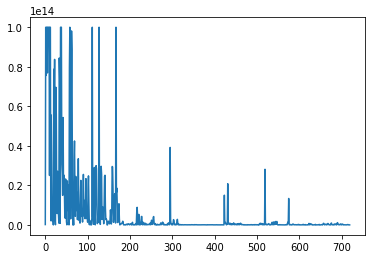

In [16]:
losses = [182428073984.0, 2698872354766848.0, 75625490546688.0, 5598057689251840.0, 3617783828971520.0, 76897060913152.0, 3303972580360192.0, 4639586881896448.0, 3386409377333248.0, 624711314702336.0, 25029249073152.0, 179943627554816.0, 108462495236096.0, 2122309959680.0, 55579426947072.0, 31442430066688.0, 4223090819072.0, 1790832803840.0, 12799042387968.0, 625700224.0, 78758769852416.0, 53508128636928.0, 83739229028352.0, 2818527199232.0, 98207023104.0, 69603761848320.0, 55693205831680.0, 6111061082112.0, 5770574299136.0, 27156230963200.0, 16952052416512.0, 6035934806016.0, 924455337984.0, 84426918723584.0, 74027334893568.0, 788700266496.0, 224136290893824.0, 422471035518976.0, 278952186740736.0, 30733030653952.0, 25758955208704.0, 14947015720960.0, 54343906623488.0, 20210671157248.0, 25182139842560.0, 18549938585600.0, 5834553163776.0, 3408439541760.0, 23233191477248.0, 20541054386176.0, 1676553617408.0, 43664281600.0, 22254826029056.0, 7319784521728.0, 15440341368832.0, 20282160971776.0, 15056271360.0, 79429271289856.0, 137693749051392.0, 77514504404992.0, 3047803584512.0, 48095362547712.0, 98119308017664.0, 88778358128640.0, 24389739347968.0, 862009600.0, 4448927088640.0, 159668496.0, 32502450225152.0, 42462634573824.0, 17752840470528.0, 4341763932160.0, 24517550276608.0, 7266345418752.0, 8781443366912.0, 16382062231552.0, 2672812883968.0, 13855413501952.0, 33479901315072.0, 11767465902080.0, 2225532829696.0, 6684810412032.0, 922667843584.0, 13763877011456.0, 22520054939648.0, 8548992417792.0, 4303865511936.0, 7647724568576.0, 1448946696192.0, 13912929992704.0, 25547688116224.0, 8234810736640.0, 4432363782144.0, 12410091995136.0, 3138360967168.0, 9248009355264.0, 23400361754624.0, 8845580566528.0, 3225752436736.0, 5510164643840.0, 1397384019968.0, 17606398443520.0, 24795022360576.0, 10323240157184.0, 168886484992.0, 2296812929024.0, 44039540736.0, 388463001600.0, 741186666496.0, 250398976.0, 3467528110080.0, 568281014468608.0, 4102334185472.0, 5966851473408.0, 318554144768.0, 16341418377216.0, 29049470582784.0, 18405524504576.0, 35280109568.0, 23015603568640.0, 29970227265536.0, 28335360966656.0, 10229315010560.0, 641626603520.0, 4217166102528.0, 2681399672832.0, 1327311355904.0, 349550946549760.0, 7584031440896.0, 6729624453120.0, 267088445440.0, 15317689434112.0, 29659047657472.0, 25635204366336.0, 2763161600000.0, 3695983198208.0, 9011931906048.0, 6148718592000.0, 592798351360.0, 9565250781184.0, 24567506534400.0, 25123633496064.0, 8479662669824.0, 2697556656128.0, 3007009259520.0, 2502654427136.0, 13470619648.0, 9593027584.0, 1546180362240.0, 1919241682944.0, 1562890076160.0, 897436024832.0, 554176020480.0, 2648753045504.0, 7601120608256.0, 3514871316480.0, 466838749184.0, 6084900159488.0, 29556194934784.0, 29283703586816.0, 18029024903168.0, 1299515703296.0, 4936652816384.0, 13095272448000.0, 15742722375680.0, 9267122798592.0, 965825069056.0, 210800434216960.0, 16473020956672.0, 18605479559168.0, 10633409986560.0, 1203648200704.0, 1758118150144.0, 6158968946688.0, 10703458009088.0, 3095094362112.0, 25407084544.0, 387049455616.0, 227942268928.0, 573103472640.0, 768421396480.0, 736665141248.0, 1102797209600.0, 1871675785216.0, 989127704576.0, 22855241728.0, 102995099648.0, 29508540416.0, 1684568832.0, 48831053824.0, 10300930048.0, 325160534016.0, 385011548160.0, 163878830080.0, 58673434624.0, 454876725248.0, 580900028416.0, 290719399936.0, 328551923712.0, 37441474560.0, 293883805696.0, 401476845568.0, 631850139648.0, 89895329792.0, 16621527040.0, 868746067968.0, 1304811536384.0, 89746677760.0, 33610072064.0, 25001459712.0, 4151160576.0, 67605458944.0, 67183603712.0, 542976671744.0, 653484687360.0, 9888612352.0, 6483755925504.0, 8886876635136.0, 4157578149888.0, 31851362304.0, 3803986001920.0, 5313273004032.0, 3297688944640.0, 6912259584.0, 41953689600.0, 1169058299904.0, 241480351744.0, 4235739529216.0, 4260867866624.0, 210824691712.0, 68786339840.0, 1354962305024.0, 178581454848.0, 808964456448.0, 941753761792.0, 29650946048.0, 43978702848.0, 802200551424.0, 464655581184.0, 110375444480.0, 38584156160.0, 269326221312.0, 227062251520.0, 182701113344.0, 312140660736.0, 170184720384.0, 144349085696.0, 444042969088.0, 1007184838656.0, 49848598528.0, 1328560472064.0, 2369013415936.0, 1878216802304.0, 248055300096.0, 1112185372672.0, 3752794259456.0, 4229449383936.0, 1171549716480.0, 147720699904.0, 581655986176.0, 685194870784.0, 3242220544.0, 5504081920.0, 180688322560.0, 26398775296.0, 321622540288.0, 201718202368.0, 44177735680.0, 37479796736.0, 202361880576.0, 155562409984.0, 617149824.0, 453603917824.0, 1042326159360.0, 599171596288.0, 133870190592.0, 513529905152.0, 1399312089088.0, 1217830846464.0, 545621180416.0, 11478926336.0, 212148912128.0, 248886738944.0, 19993888768.0, 71949746176.0, 21973764096.0, 4543198208.0, 162434990080.0, 396951027712.0, 2010939520.0, 806329909248.0, 970906730496.0, 1094177718272.0, 61427392512.0, 1244724068352.0, 39199063408640.0, 2344716599296.0, 644807786496.0, 89823084544.0, 535207837696.0, 242477449216.0, 983355520.0, 991342821376.0, 2677986557952.0, 1808344547328.0, 574920327168.0, 27885744128.0, 240362225664.0, 265107849216.0, 2896942336.0, 517800787968.0, 1397892448256.0, 2812702883840.0, 790210740224.0, 38706823168.0, 490219831296.0, 280274960384.0, 998401984.0, 3063401216.0, 167346847744.0, 112882221056.0, 31810148352.0, 14060505088.0, 119755448320.0, 109101064192.0, 44495683584.0, 30411347968.0, 53643657216.0, 40151343104.0, 89308635136.0, 76037513216.0, 72648843264.0, 56988672000.0, 69373239296.0, 57188896768.0, 57722466304.0, 34639724544.0, 78890762240.0, 61851938816.0, 56018370560.0, 30688557056.0, 85413273600.0, 61863628800.0, 45786157056.0, 30546651136.0, 111777554432.0, 94071635968.0, 43364524032.0, 45487505408.0, 83752361984.0, 68054982656.0, 38874628096.0, 33147299840.0, 138869506048.0, 102463692800.0, 46022692864.0, 54764425216.0, 110027546624.0, 82683568128.0, 79165980672.0, 28555085824.0, 61345755136.0, 40316424192.0, 37532475392.0, 39485267968.0, 47167803392.0, 24723316736.0, 39875497984.0, 39455666176.0, 78512603136.0, 62174674944.0, 67933732864.0, 63967514624.0, 50542235648.0, 32216479744.0, 100922490880.0, 42747215872.0, 60454760448.0, 41412861952.0, 62630567936.0, 52256587776.0, 36415897600.0, 13091593216.0, 107252645888.0, 50661683200.0, 52980531200.0, 47337791488.0, 97725014016.0, 95356207104.0, 54518747136.0, 42360639488.0, 69494710272.0, 52477644800.0, 41992617984.0, 22485751808.0, 88537489408.0, 74728972288.0, 21665484800.0, 15630625792.0, 59184672768.0, 46965608448.0, 39144624128.0, 30578993152.0, 81978859520.0, 79195242496.0, 28396126208.0, 13283023872.0, 52859297792.0, 35004166144.0, 23985723392.0, 18771740672.0, 40375377920.0, 33231923200.0, 8882685952.0, 8382180864.0, 80024485888.0, 34501484544.0, 30822629376.0, 19203307520.0, 47023165440.0, 54236819456.0, 33605214208.0, 12377340928.0, 15035048919040.0, 793457852416.0, 1318669778944.0, 1083019034624.0, 361863610368.0, 41003212800.0, 293487640576.0, 338141085696.0, 20844935905280.0, 506941145088.0, 1048102961152.0, 936236220416.0, 242878447616.0, 260123967488.0, 820661125120.0, 532790509568.0, 24185847808.0, 264580612096.0, 630267707392.0, 531278430208.0, 102188105728.0, 271845441536.0, 1030911229952.0, 450661154816.0, 127481487360.0, 155979579392.0, 483797106688.0, 441523372032.0, 81223860224.0, 133103845376.0, 433815879680.0, 612828708864.0, 26709364736.0, 191642566656.0, 661626093568.0, 597682814976.0, 66203803648.0, 316786606080.0, 860885221376.0, 738534817792.0, 187468218368.0, 90434625536.0, 232275558400.0, 194292072448.0, 113383555072.0, 34586980352.0, 160857948160.0, 35756728320.0, 6150400.0, 98252152832.0, 23903942656.0, 36071124992.0, 68826996736.0, 6145070592.0, 142684487680.0, 42490195968.0, 19887628288.0, 95179341824.0, 21718505472.0, 5324110336.0, 74733617152.0, 63616188416.0, 39000326144.0, 149289893888.0, 77121732608.0, 126867038208.0, 7216927232.0, 12903938048.0, 113055653888.0, 69475205120.0, 27877644288.0, 753392704.0, 179960070144.0, 110566227968.0, 10204939264.0, 24745019392.0, 70857646080.0, 139655430144.0, 37023531008.0, 64281518080.0, 20511539200.0, 212789854208.0, 3706678784.0, 365475856384.0, 697192415232.0, 860489056256.0, 203729010688.0, 202141515776.0, 697427951616.0, 674318516224.0, 111772540928.0, 97934884864.0, 511225004032.0, 227858726912.0, 4591417344.0, 416581189632.0, 28142095826944.0, 600338268160.0, 161038680064.0, 88312389632.0, 321448181760.0, 247510237184.0, 69746040832.0, 218295222272.0, 431919398912.0, 667203928064.0, 221868081152.0, 6554440704.0, 188337127424.0, 173126942720.0, 16232841.0, 404609859584.0, 655715729408.0, 1347859513344.0, 544394969088.0, 3857248512.0, 624850698240.0, 1560781783040.0, 1079059218432.0, 174110081024.0, 770654404608.0, 1725001236480.0, 357544787968.0, 1194431479808.0, 1741887897600.0, 265397288960.0, 41372168192.0, 105118932992.0, 24371111936.0, 6883274240.0, 95616237568.0, 137153568768.0, 51705073664.0, 54888054784.0, 41149239296.0, 48741380096.0, 17210882048.0, 25606559744.0, 92755730432.0, 87017627648.0, 22538340352.0, 10250954752.0, 23657977856.0, 4736398848.0, 97355079680.0, 22360864768.0, 135524851712.0, 121718652928.0, 3323329.0, 596749320192.0, 1351920648192.0, 972923797504.0, 13374495653888.0, 137491709952.0, 18392377344.0, 128119431168.0, 134170746880.0, 218493845504.0, 8173606400.0, 11887595520.0, 853314.0625, 204690636800.0, 464943972352.0, 341400059904.0, 99356557312.0, 20101001216.0, 127306596352.0, 147738755072.0, 116724719616.0, 28107444224.0, 108164194304.0, 65302224896.0, 1116963200.0, 129409269760.0, 222258036736.0, 126973919232.0, 220842655744.0, 18879024.0, 68540547072.0, 74444120064.0, 6904155648.0, 10151267328.0, 59223601152.0, 56863531008.0, 37067128832.0, 62940901376.0, 282196017152.0, 181360787456.0, 2094206464.0, 14225988608.0, 66188881920.0, 169600450560.0, 2566106368.0, 26638237696.0, 24676638720.0, 719500160.0, 20642002944.0, 55051706368.0, 8877973504.0, 313863536640.0, 756658143232.0, 166070108160.0, 10972352512.0, 283854798848.0, 637660561408.0, 461068173312.0, 187398733824.0, 61180416000.0, 176447881216.0, 1094054912.0, 35916312576.0, 32497092608.0, 159542160.0, 44665544704.0, 128414900224.0, 272413016064.0, 76025320.0, 11683772416.0, 1174569984.0, 69143384.0, 90006601728.0, 45235441664.0, 27777388544.0, 82522759168.0, 255143936000.0, 33183084544.0, 17325404160.0, 30190192640.0, 963233280.0, 110422622208.0, 144942579712.0, 95032549376.0, 1963132416.0, 364371279872.0, 805053530112.0, 742864715776.0, 374221537280.0, 31785986048.0, 104089632768.0, 303745368064.0, 384084803584.0, 156199829504.0, 2780611072.0, 230606438400.0, 667420786688.0, 720783998976.0, 488731377664.0, 72891228160.0, 47106469888.0, 20657379328.0, 81246232576.0, 11042856960.0, 756484603904.0, 968843788288.0, 138849206272.0, 46796398592.0, 88253407232.0, 43626467328.0, 4078067712.0, 348406874112.0, 436183957504.0, 52449013760.0, 249136005120.0, 494232207360.0, 303154593792.0, 1846925824.0, 601166053376.0, 1146201702400.0, 845223952384.0, 177130192896.0, 90574741504.0, 202687348736.0, 185643253760.0, 10213982208.0, 265714483200.0, 536439422976.0, 316144189440.0, 14230701056.0, 172642222080.0, 429389250560.0, 301519044608.0, 42708664320.0, 19493185536.0, 72102993920.0, 51574808576.0, 5978942976.0, 34505662464.0, 56967782400.0, 65051521024.0, 11969727488.0, 51014545408.0, 166931087360.0, 177704615936.0, 66476437504.0, 2424429824.0, 8886927360.0, 22597718016.0]
plt.plot([min(loss, 1e14) for loss in losses])

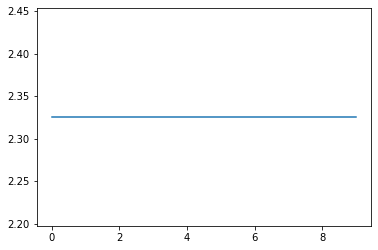

In [17]:
plt.plot(val_scores)

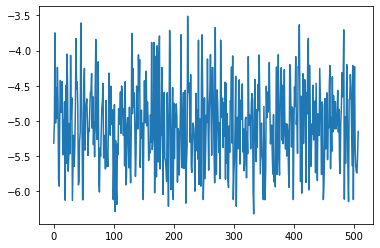

In [18]:
plt.plot(scores)

In [19]:
env.get_tour_cost()

4.59397553679417

In [20]:
score

-4.59397553679417

In [21]:
action = agent.act(state, eps=0)
action

5

In [22]:
next_state, reward, done = env.step(action)

In [23]:
next_state, reward, done

(array([[1.        , 0.        , 0.88425712, 0.45431075, 0.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 0.        ,
         0.90463867, 0.107927  , 0.6807273 , 0.45897507, 0.55331436,
         0.2399829 , 0.28335334, 0.3562668 , 0.31947314],
        [1.        , 0.        , 0.07203433, 0.85263883, 1.        ,
         0.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 0.90463867,
         0.        , 0.79671166, 0.25064306, 1.06330517, 0.39891378,
         0.66715825, 1.11789495, 0.59327729, 0.77475816],
        [1.        , 0.        , 0.78735968, 0.501841  , 1.        ,
         1.        , 0.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 0.107927  ,
         0.79671166, 0.        , 0.57412141, 0.48418438, 0.45014088,
         0.1335509 , 0.36581448, 0.26035822, 0.2748034 ]

In [24]:
agent.step(state, action, reward, next_state, done)

In [25]:
agent.t_step

9

In [26]:
state = next_state

In [27]:
action = agent.act(state, eps=0)
action

0

In [ ]:
env.G[0].get(0, float('inf'))

In [ ]:
env.reset()
print(env.n)

dist_matrix = np.array([[env.G[u].get(v, {}).get("weight", float('inf')) for v in range(env.n)] for u in range(env.n)])

start_time1 = time.time()
ans1 = solve(env.G)
end_time1 = time.time()
print(ans1, end_time1-start_time1)

start_time2 = time.time()
ans2 = solve2(env.G)
end_time2 = time.time()
print(ans2, end_time2-start_time2)

start_time3 = time.time()
ans3 = solve_tsp_dynamic_programming(dist_matrix)[1]
end_time3 = time.time()
print(ans3, end_time3-start_time3)

In [ ]:
fig, ax = plot_network(env.G)
fig.set_size_inches(6, 6)

In [ ]:
def run_episode(model, train_mode=True, eps=0.01, if_train_then_step=True):
    """Runs a single episode of the environment"""    
    env_info = env.reset()
    model.update_model_info(env_info.G)
    score = 0
    while True:
        action = agent.act(state, eps)
        env_info = env.step()
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        if train_mode and if_train_then_step:
            model.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    return score

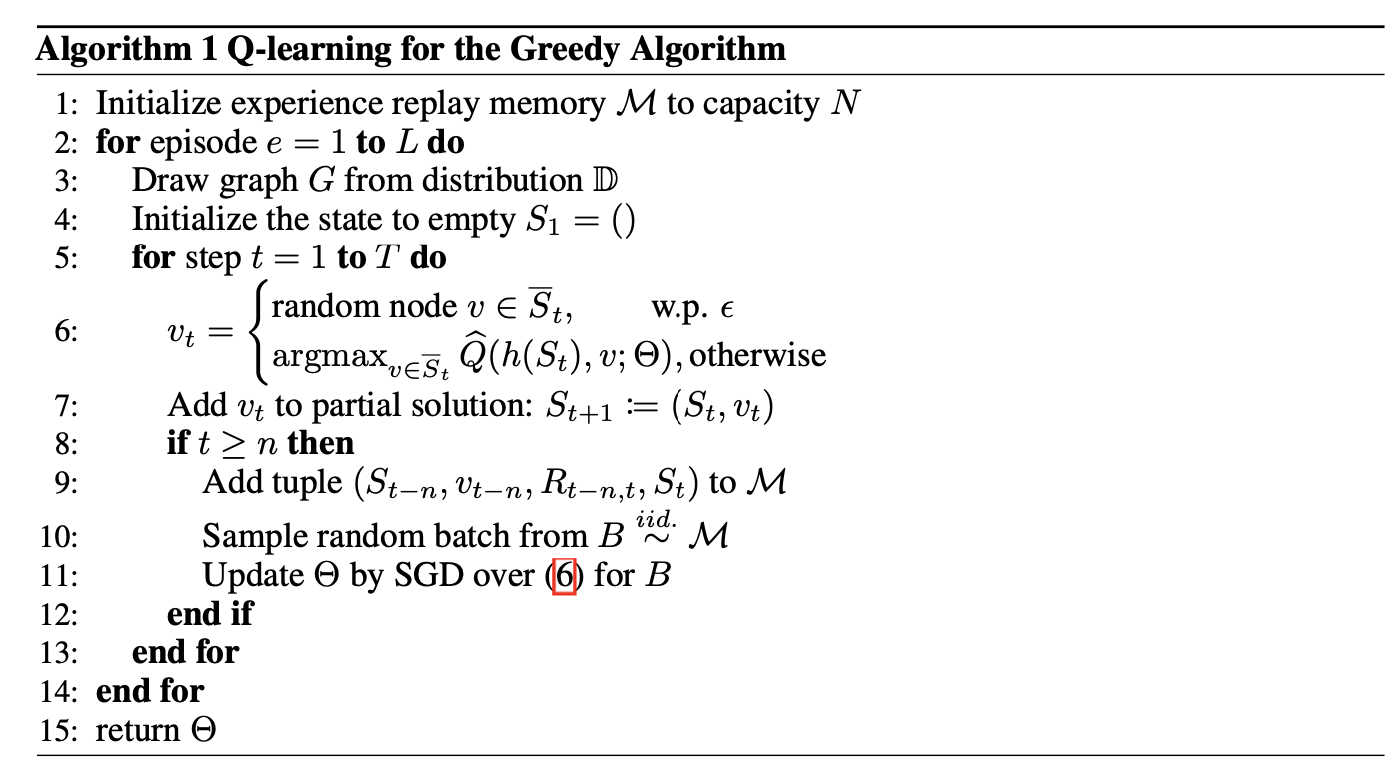

In [ ]:
def train(agent, env, buffer, graph_gen, nstep):
    G = graph_gen.sample()
    env_info = env.reset()
    agent.reset_episode()
    N = G.number_of_nodes()
    S = state = []
    for step in range(1, n+1):
        action = agent.act(state)
        env_info = env.step(action)
        # next_state, reward, done = env.step(action)
        agent.step(self, state, action, env_info.reward, env_info.next_state, env_info.done):
        S.append(v)
        state = next_state
        if done:
            break
        
#         if step >= nstep:
#             buffer.add((*S[step-nstep], R, state))
#             batch = buffer.sample()
#             model.learn(batch)
            
            
            
#         env_info = env.step(action)[brain_name]        # send the action to the environment
#         next_state = env_info.vector_observations[0]   # get the next state
#         reward = env_info.rewards[0]                   # get the reward
#         done = env_info.local_done[0]                  # see if episode has finished
#         score += reward                                # update the score
#         if train_mode and if_train_then_step:
#             agent.step(state, action, reward, next_state, done) # step in the agent model
#         state = next_state                             # roll over the state to next time step
#         if done:                                       # exit loop if episode finished
#             break
    return score